In [7]:
!pip install fastcoref
speech_of_dr_apj= """A P J Abdul Kalam Departing speech
Friends, I am delighted to address you all, in the country and those living abroad, after
working with you and completing five beautiful and eventful years in Rashtrapati
Bhavan. Today, it is indeed a thanks giving occasion. I would like to narrate, how I
enjoyed every minute of my tenure enriched by the wonderful association from each one
of you, hailing from different walks of life, be it politics, science and technology,
academics, arts, literature, business, judiciary, administration, local bodies, farming,
home makers, special children, media and above all from the youth and student
community who are the future wealth of our country. During my interaction at
Rashtrapati Bhavan in Delhi and at every state and union territory as well as through my
online interactions, I have many unique experiences to share with you, which signify the
following important messages:
1. Accelerate development : Aspiration of the youth,
2. Empower villages,
3. Mobilize rural core competence for competitiveness,
4. Seed to Food: Backbone for agricultural growth
5. Defeat problems and succeed,
6. Overcome problems through partnership,
7. Courage in combating calamities,
8. Connectivity for societal transformation,
9. Defending the nation: Our pride and
10. Youth movement for Developed India 2020.
Now let me share with you each of the messages.
Accelerate Development: Aspiration of the youth
While there were many significant events during my tenure, a question from a little girl
Anukriti of Sri Sathya Sai Jagriti Vidya Mandir School, of Darwa village from Haryana,
during children’s visit to Rashtrapati Bhavan on May 22, 2006, rings in my mind ever
after.
Anukriti asked me “why India cannot become a developed nation before the year 2020”. I
appreciated the question and said it was indeed a thoughtful question and assured her that
that her dream would be taken to the highest institution of the nation and we would work
for it to achieve before 2020. This question reflects how the desire to live in developed
India has entered into the minds of the youth. The same feelings are echoed by over
fifteen lakh youth, whom I have met so far and who represent the dream of the 540
million youth of the nation. The aspirations of the young to live in a prosperous, safe and
proud India should be the guiding factor in whatever profession we contribute.
Empower Villages
Friends, I recall my visit to Nagaland on 26th October 2002, soon after my assuming
office as President. It was a unique experience for me at Khuzama village to meet tribal
village council members and discuss with them the village progress and the dream of
village citizens. I was very happy to see the empowered village council functioning with
financial powers and taking decisions. I saw a prosperous village with fruits and
vegetables production. However, there is a need for providing physical connectivity in
Nagaland through quality roads for enabling faster movement of products from villages
to the market. That meeting gave me a powerful message about the transformation which
can take place to the 600,000 villages of India, if all the villages are empowered to deal
with their development and are well connected among themselves and with the urban
societies.
Mobilizing rural core competence for competitiveness
Now I would like to talk about the initiative of Periyar Maniammai College of
Technology for Women, Vallam, Tanjore of Providing Urban Amenities in Rural Areas
(PURA) complex involving 65 villages with a population of 3 lakhs. This includes
provision of three connectivities - physical, electronic and knowledge - leading to
economic connectivity. Periyar PURA has health care centers, primary to post graduate
level education and vocational training centers. This has resulted in large-scale
employment generation and creation of number of entrepreneurs with the active support
of 1000 self-help groups. Two hundred acres of waste land has been developed into a
cultivable land. The villagers are busy in cultivation, planting Jatropha, herbal and
medicinal plants, power generation using bio-mass, food processing and above all
running marketing centers. It provides a sustainable economic development model for the
whole region.
During the last eight months, people of Periyar PURA villages technologically supported
by Periyar Maniammai College of Engineering for Women have worked with experts
from Japan External Trade Organisation (JETRO) on various products, for which core
competence and raw material are available in Thanjavur district. They developed
internationally competitive prototypes for 55 life style products with support of JETRO
specialists and feedback from exhibitions at Delhi and Tokyo. This co-operative venture
has enhanced the innovative ability of the people of all the 65 villages enabling them to
develop and produce internationally acceptable products. I have seen similar type of
PURA being established in many states. The whole country needs 7000 PURA to
bridging the rural – urban divide.
Seed to Food: Backbone for agricultural growth
Let me now share with you, the enriching experience I had, while meeting more than
6000 farmers from different States and Union Territories visiting Rashtrapati Bhavan.
They evinced keen interest in the Mughal Gardens, the Herbal Gardens, the Spiritual
Garden, the Musical Garden, the Bio-diesel garden and the Nutrition Garden and interact
with the Horticultural specialists. Recently, during my address to the agricultural
scientists while participating in a National Symposium on “Agriculture Cannot Wait”, I
summarized the many practical suggestions given by farmers. We have to double the
agricultural production with reduced land, reduced water resources and reduced
manpower and improve the economic conditions of the nation through the principle of
“Seed to Food” since agriculture is the backbone of the nation. We should empower the
farmers to protect and nurture the fertile land for second green revolution. Meeting the
Scientists and the Farmers has given me the confidence
that the nation is poised to increase the agricultural GDP growth by atleast 4% per annum
through the partnership of farmers and agricultural scientists and industries particularly
for value addition.
Defeat the problems and succeed
On the evening of February 24, 2007, at Coimbatore, I had a very beautiful experience.
As I got ready for meeting the first person out of twenty appointments, a wheel chair was
in sight with a smiling person probably in his late fifties; unfortunately he has no hands
and legs. His radiant face was revealing his happy state of mind. He introduced himself
as Vidwan Coimbatore SR Krishna Murthy. I greeted him and asked him how this had
happened. He smilingly said that it was from by birth. He thanked God, his parents,
teachers and many others for giving him confidence, training and help. I asked him, what
I could do for him? He said, “I don’t need anything from you. I would like to sing in front
of you”. I readily agreed. He sang melodiously the Saint Thyagraja’s pancha ratna kriti
entharo mahanubavulu in Sriragam giving me a glimpse of his talent. I was quite touched.
What is the message? Despite being physically challenged, the latent talent of music
could blossom in this
person with his positive attitude and perseverance, encouraged by the parents, teachers,
academics and rasikas. Now he wants to give, give and give his art to inspire others. Of
course, by his merit of music, in July 2007, he performed in the Rashtrapati Bhavan art
theatre.
Overcome the impact of disaster through partnership
I had the opportunity to experience the Indomitable Spirit of the people and children of
Jammu & Kashmir even as they were just recovering from the devastating earthquake in
2005. I visited Urusa village on 26th November 2005 which has been adopted by the
Western Air Command, Air Force for providing relief and medical aid to the residents of
that area. When I went there, I found that the school building had been severely damaged.
I met all the school children and the village citizen of Urusa. The villagers apprised me of
their losses and had all praise for Army and Air Force role in rescue and relief operations
along with state government. I appreciate the courage of the people of Urusa in defeating
their problems. They have actually become the master of the problem rather than
allowing problems to become their master. Despite the severe loss due to the earthquake,
the children and the members of the village participated in the relief operation with the
Armed Forces
bravely and were smiling when I went to meet them. They interacted with me and said
that the school was functional in the temporary tents. Here, I also witnessed the
participation of acting Chief Justice of Jammu & Kashmir along with State Government
authorities in on-the-spot settlement of relief grants to be provided to the victims whose
houses had been damaged in the earth quake. I have experienced many such acts of
courage from our citizens when faced with severe challenges.
Courage in combating calamities
In 2005, I met the Tribal Council Leaders, Students, Children of Chuckchucha village
during my visit to Car Nicobar Islands. While various reconstruction and rehabilitation
activities were in progress, during the discussions with the members of tribal council, I
realized the unique trait among the Car-Nicobar islanders. Even though there were many
human losses due to the Tsunami of 26 Dec 2004, the tribal islanders had taken
possession of affected victims as their children and there is nothing like orphanage in
Car-Nicobar Islands. Touched by their courage, I composed few verses called “Sea
Waves” which reads as follows:
Sea Waves
We are the children of Sea waves,
Sea waves are my friends.
When they become angry,
Sea waves give the challenges.
God has given the courage,
To challenge the sea waves.
And we will succeed,
We will succeed
With Almighty’s grace.
All the members who were gathered in the village sang the poem with me and exhibited
lots of courage and enthusiasm even though they had gone through severe suffering
during the Tsunami.
Connectivity for societal transformation
I addressed the Pan African Parliament on 16 September 2004, at Johannesburg, South
Africa. This was attended by 53 member countries of the African Union, where I
proposed the concept of Pan African e-Network for providing seamless and integrated
satellite, fiber optics and wireless network connecting 53 African countries at an
estimated cost of US $ 100 million.
As part of the project 12 universities (7 from India and 5 from Africa), 17 Super
Specialty Hospitals (12 from India and 5 from Africa), 53 tele-medicine centers and 53
tele-education centres in Africa will be connected. The pilot project on tele-education and
tele-medicine in Ethiopia has already been commissioned. Indira Gandhi National Open
University has taken up the MBA Course for 34 Ethiopian students of Addis Ababa and
Harmaya Universities. As regards, tele-medicine, the specialists from CARE Hospital,
Hyderabad are providing one-hour live tele-consultation to doctors in Black Lion
Hospital, Addis Ababa in Cardiology and Radiology since November 2006. Using the
Pan African network the Heads of the State in all the 53 countries will be connected for
instant communication. I am extremely happy that Indian experience in bringing the
benefits of technology to the people has enabled us to work with Africa to bring societal
transformation in the African continent.
Defending the nation: Our pride
I visited KUMAR in Siachen Glacier located at 17,000 feet altitude held by the Indian
Army, had a memorable underwater journey in INS Sindhurakshak and flew in a Sukhoi
30 fighter experiencing 2.5 g. In these three experiences, I personally felt proud of our
ever vigilant Soldiers, Sailors and Air Warriors performing their tasks beyond the call of
their duty even in the most adverse circumstances natural and man made. During the last
five years, I had an opportunity to present colours to many regiments, participate in
number of passing out parades, meet the troops who were going to undertake peace
missions and interact with the family members of our Defence Forces. Our Defence
Forces are in a beautiful mission. When the nation sleeps during night, Members of our
Defence teams are awake to guard us and remain vigilant to counter any threat. The
Nation cherishes the valour, commitment and devotion to duty of our Defence Forces.
Similarly, I had opportunities to interact
with members of our para-military forces, central and state police personnel including
internal security forces who are making immense contribution in augmenting the safety
and security of our citizens under difficult conditions.
Youth movement for Developed India 2020
Recently, in Hyderabad, I met a group of citizens who are putting into practice the motto
of transforming of our youth into enlightened citizen. The Lead India 2020 Foundation
created by Dr. N.B. Sudershan at Hyderabad is training thousands of students in many
districts of Andhra Pradesh in partnership with the District Administration. Particularly, I
happened to know the transformation which has taken place among the students of
Medak district. As per the district authorities the impact of the training on the students is
visible in terms of self-discipline, love for their parents and teachers shedding of stage
fear and recognition of their duties towards the nation. I talked to Ms. Padma, a student
leader from Andhra Pradesh Tribal Welfare School, Nalgonda who related how she
weaned her father away from smoking after imbibing the spirit of the 10 point oath from
the Lead India Training Camp. This gives me an assurance that the youth of our country
are on the right path
through this mission oriented programme. With the ignited minds of the 540 million
youth below the age of 25, which I consider is the most powerful resource on the earth,
under the earth and above the earth, we have to empower the youth through value based
education and leadership.
Conclusion
I was touched by the variety of Indian panorama, emotional content of the tune, cultural
diversity and unity of minds in the vast land of ours. I have cited these examples just to
give a glimpse of the richness of our tradition and effort being taken by different agencies
to preserve it. There are also many new adventures by institutions and individuals. I have
experienced many of them and learnt a lot about my country and our people. Even while
pursuing our economic growth, we need to do a lot to preserve the rich and diverse
treasures of our culture and civilization. It is our duty for our future generations. This has
to be done in a much larger scale through countrywide participation of multiple
institutions. Our country is blessed with natural resources, has shown considerable
progress in the last sixty years, and above all we have hard working people particularly
the power of the 540 million youth of the country. Every sector of our country has given
me the
confidence that India can become a developed nation well before 2020. Whomsoever, I
met they constantly ask what they can give to the nation. We should constantly strive to
empower such members of the society. With this spirit, I am extremely happy that we are
on the right path. Here I am reminded of a famous poem:
"When you wish upon a star,
Makes no difference who you are,
Anything your heart desires,
Will come to you”
This poem is true to all of us, and particularly for our youth and if they aim great, I am
sure they will reach close to the target or the target.
My dear citizens, let us resolve to continue to work for realizing the missions of
developed India 2020 with the following distinctive profile.
1. A Nation where the rural and urban divide has reduced to a thin line.
2. A Nation where there is an equitable distribution and adequate access to energy and
quality water.
3. A Nation where agriculture, industry and service sector work together in symphony.
4. A Nation where education with value system is not denied to any meritorious
candidates because of societal or economic discrimination.
5. A Nation which is the best destination for the most talented scholars, scientists, and
investors.
6. A Nation where the best of health care is available to all.
7. A Nation where the governance is responsive, transparent and corruption free.
8. A Nation where poverty has been totally eradicated, illiteracy removed and crimes
against women and children are absent and none in the society feels alienated.
9. A Nation that is prosperous, healthy, secure, peaceful and happy and continues with a
sustainable growth path.
10. A Nation that is one of the best places to live in and is proud of its leadership.
Finally let me thank each one of you for showering your love and affection on me
throughout the last five years by your cooperation and support.
Dear Citizens, I conclude my address by sharing with you my mission in life which is to
bring connectivity between billion hearts and minds of the people of India in our
multicultural society and to embed the self confidence that "we can do it". I will be
always with you, dear citizens, in the great mission of making India a developed nation
before 2020.
May God bless you.
Jai hind.
"""
with open("sample.txt", "w") as f:
    f.write(speech_of_dr_apj)

from fastcoref import FCoref

# Read from sample.txt
with open("sample.txt", "r") as f:
    text = f.read()
    coref = FCoref()
doc = coref.predict(text)
print(doc.get_clusters())
from sentence_transformers import SentenceTransformer, util
from fastcoref import FCoref
from typing import List, Dict, Tuple
import spacy
import torch
import matplotlib.pyplot as plt
nlp = spacy.load("en_core_web_sm")
sentModel = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
corefmodel = FCoref(device='cuda')  # GPU of  NVIDIA GeForce RTX 2050  CUDA Version: 12.5


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00
  Created wheel for fastcoref: filename=fastcoref-2.1.6-py3-none-any.whl size=31254 sha256=a972be7d0e27f8ece886f6927eb9b7efa3166dc948e8a1b9b1619fdb61e04184
  Sto

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/393 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/362M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/362M [00:00<?, ?B/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

[['P J Abdul Kalam', 'I', 'I', 'I', 'my', 'my', 'my', 'I', 'me', 'my', 'my', 'me', 'I', 'I', 'I', 'my', 'my', 'me', 'I', 'I', 'me', 'I', 'I', 'me', 'I', 'my', 'I', 'me', 'I', 'I', 'I', 'I', 'I', 'you', 'you', 'I', 'me', 'I', 'I', 'I', 'I', 'I', 'I', 'me', 'I', 'I', 'me', 'I', 'I', 'I', 'my', 'I', 'I', 'me', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'me', 'I', 'I', 'I', 'I', 'my', 'me', 'I', 'I', 'I', 'I', 'My', 'me', 'me', 'I', 'my', 'my', 'I'], ['Friends', 'you', 'you', 'you', 'you', 'you', 'My dear citizens', 'you', 'your', 'your', 'Dear Citizens', 'you', 'you', 'dear citizens', 'you'], ['the country', 'our country', 'the nation', 'India', 'the nation', 'developed\nIndia', 'the nation', 'India', 'The whole country', 'the nation', 'the nation', 'the nation', 'the nation', 'the nation', 'our', 'us', 'The\nNation', 'our', 'the nation', 'our country', 'my country', 'Our country', 'the country', 'our country', 'India', 'the nation', 'its', 'India', 'our', 'India'], ['\nRashtrapati

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
def replace_mentions(text: str) -> str:
    """
    Resolves pronouns in text using FastCoref and replaces them with their referents.
    Returns the resolved text.
    """
    # FastCoref requires list input
    predictions = corefmodel.predict([text])
    prediction = predictions[0]  # Get first (only) prediction

    print(f"\n📌 Original: {text}")

    # Get the actual span clusters - this is the key fix!
    # Use get_clusters(as_strings=False) to get span coordinates
    try:
        # Try different ways to access clusters based on FastCoref version
        if hasattr(prediction, 'get_clusters'):
            clusters = prediction.get_clusters(as_strings=False)
        elif hasattr(prediction, 'clusters'):
            clusters = prediction.clusters
        else:
            # Fallback - access clusters directly from prediction attributes
            clusters = getattr(prediction, '_clusters', [])
    except Exception as e:
        print(f"Error accessing clusters: {e}")
        return text

    # For debugging - print raw clusters
    print(f"  Raw clusters: {clusters}")

    # Build replacement map: {(start, end) -> replacement_text}
    replacements: Dict[Tuple[int, int], str] = {}

    for cluster in clusters:
        if not cluster or len(cluster) < 2:  # Need at least 2 mentions for coreference
            continue

        print(f"  Processing cluster: {cluster}")

        # Find the best referent (usually the first non-pronoun mention)
        main_referent = None
        main_text = ""

        for span in cluster:
            if not isinstance(span, (tuple, list)) or len(span) != 2:
                continue

            start, end = span
            span_text = text[start:end]

            # Skip pronouns for main referent selection
            if span_text.lower() not in {'it', 'he', 'she', 'they', 'him', 'her', 'them', 'his', 'hers', 'its', 'their'}:
                main_referent = span
                main_text = span_text
                break

        # If no non-pronoun referent found, use the first mention
        if main_referent is None and cluster:
            main_referent = cluster[0]
            main_text = text[main_referent[0]:main_referent[1]]

        print(f"     Main referent: '{main_text}' at {main_referent}")

        # Replace pronouns in this cluster
        for span in cluster:
            if not isinstance(span, (tuple, list)) or len(span) != 2:
                continue

            start, end = span
            mention_text = text[start:end]

            # Only replace pronouns, and don't replace the main referent with itself
            if (mention_text.lower() in {'it', 'he', 'she', 'they', 'him', 'her', 'them'}
                and span != main_referent):
                replacements[(start, end)] = main_text
                print(f"   🔄 Will replace '{mention_text}' ({start}-{end}) with '{main_text}'")

    # Apply replacements in reverse order (to preserve positions)
    resolved_text = text
    for (start, end) in sorted(replacements.keys(), reverse=True):
        resolved_text = resolved_text[:start] + replacements[(start, end)] + resolved_text[end:]

    print(f"    Resolved: {resolved_text}")
    return resolved_text



print("=== Testing Version 1 ===")
newtext = replace_mentions(text)
def split_sentences(text):
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]

def should_merge(s1, s2, soft_conj=("and", "but", "because"), embed_sim_threshold=0.35):
    conjunction_flag = s2.lower().startswith(tuple(w + ' ' for w in soft_conj))
    e1 = sentModel.encode(s1, convert_to_tensor=True)
    e2 = sentModel.encode(s2, convert_to_tensor=True)
    sim = util.pytorch_cos_sim(e1, e2).item()
    embed_flag = sim >= embed_sim_threshold
    return conjunction_flag and embed_flag

def smart_merge_conj_embed(sentences, soft_conj=("and", "but", "because"), embed_sim_threshold=0.35):
    merged = []
    buffer = sentences[0]
    for i in range(1, len(sentences)):
        curr = sentences[i]
        if should_merge(buffer, curr, soft_conj, embed_sim_threshold):
            buffer += " " + curr
        else:
            merged.append(buffer.strip())
            buffer = curr
    merged.append(buffer.strip())
    return merged

def process_text(text):
    sentences = split_sentences(text)
    sentences = [s for s in sentences if len(s.split()) >= 3]
    merged_sentences = smart_merge_conj_embed(sentences)
    return merged_sentences

# 👇 This line MUST be run to define `result`
result = process_text(text)
for i, s in enumerate(result):
    print(f"[{i}] {s}")

=== Testing Version 1 ===


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]


📌 Original: A P J Abdul Kalam Departing speech
Friends, I am delighted to address you all, in the country and those living abroad, after
working with you and completing five beautiful and eventful years in Rashtrapati
Bhavan. Today, it is indeed a thanks giving occasion. I would like to narrate, how I
enjoyed every minute of my tenure enriched by the wonderful association from each one
of you, hailing from different walks of life, be it politics, science and technology,
academics, arts, literature, business, judiciary, administration, local bodies, farming,
home makers, special children, media and above all from the youth and student
community who are the future wealth of our country. During my interaction at
Rashtrapati Bhavan in Delhi and at every state and union territory as well as through my
online interactions, I have many unique experiences to share with you, which signify the
following important messages:
1. Accelerate development : Aspiration of the youth,
2. Empower villages

Processing speech and predicting completion:

Batch  | Topics | Novelty | Staleness | Completion | Status
----------------------------------------------------------------------
1      | 4      | 1.0000  | 0.0000    |    0.0%    | [                    ]
2      | 3      | 1.0000  | 0.0000    |    3.7%    | [                    ]
3      | 5      | 1.0000  | 0.0000    |    3.0%    | [                    ]
4      | 3      | 0.9024  | 0.2441    |    7.9%    | [=                   ]
5      | 4      | 0.8943  | 0.2642    |   11.3%    | [==                  ]
6      | 4      | 0.9268  | 0.0000    |   12.7%    | [==                  ]
7      | 5      | 1.0000  | 0.0000    |   12.7%    | [==                  ]
8      | 5      | 0.9414  | 0.0000    |   13.4%    | [==                  ]
9      | 2      | 0.7887  | 0.5283    |   17.5%    | [===                 ]
10     | 5      | 1.0000  | 0.0000    |   18.6%    | [===                 ]
11     | 5      | 1.0000  | 0.0000    |   18.3%    | [===      

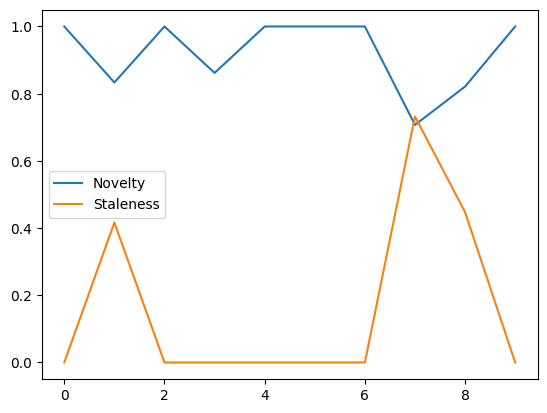

In [11]:
import re
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from collections import deque
from transformers import AutoTokenizer
from sklearn.cluster import AgglomerativeClustering

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# text preprocessing functions
def clean_text_spacing(text):
    text = re.sub(r'(?<=[.!?])(?=\w)', r' ', text)
    text = re.sub(r'(?<=[.,!?;:])(?=\S)', r' ', text)
    return text

def split_into_sentences(text):
    sentence_endings = re.compile(r'(?<=[.!?])\s+(?=[A-Z])')
    return sentence_endings.split(text)

# Load sample text

cleaned_text = clean_text_spacing(text)
sentences = split_into_sentences(cleaned_text)

# Initialize model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Topic tracking and novelty detection system


class TopicTracker:
    def __init__(self, novelty_decay=0.2, staleness_threshold=0.65):
        self.topics = {}  # topic_id: {'centroid', 'last_seen', 'count'}
        self.next_topic_id = 0
        self.novelty_decay = novelty_decay
        self.staleness_threshold = staleness_threshold
        self.novelty_history = deque(maxlen=10)
        self.staleness_history = deque(maxlen=10)

    def update_topics(self, batch_embeddings):
        """Cluster sentences and update topic registry"""

        # Convert to numpy
        embeddings_np = (
            batch_embeddings.cpu().numpy()
            if isinstance(batch_embeddings, torch.Tensor)
            else batch_embeddings
        )

        if embeddings_np.shape[0] < 2:
            # Only one sentence — treat it as a new topic
            topic_id = self._match_or_create_topic(embeddings_np[0])
            return {topic_id: [0]}

        # Otherwise, do clustering new one agglomerative clustering
        clustering = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=0.5,
            metric='cosine',
            linkage='average'
        )
        labels = clustering.fit_predict(embeddings_np)

        # Process clusters
        batch_topics = {}
        for label in set(labels):
            if label == -1:
                # Handle noise as individual topics
                for i in np.where(labels == label)[0]:
                    topic_centroid = embeddings_np[i]
                    topic_id = self._match_or_create_topic(topic_centroid)
                    batch_topics[topic_id] = batch_topics.get(topic_id, []) + [i]
            else:
                indices = np.where(labels == label)[0]
                topic_centroid = np.mean(embeddings_np[indices], axis=0)
                topic_id = self._match_or_create_topic(topic_centroid)
                batch_topics[topic_id] = batch_topics.get(topic_id, []) + list(indices)

        return batch_topics  #  Return after processing all labels

    def _match_or_create_topic(self, new_centroid):
        # Dummy matching function for now (you can replace this with actual similarity logic)
        topic_id = self.next_topic_id
        self.topics[topic_id] = {'centroid': new_centroid, 'last_seen': 0, 'count': 1}
        self.next_topic_id += 1
        return topic_id

    def _match_or_create_topic(self, centroid):
        """Match to existing topic or create new one"""
        best_match = None
        best_sim = -1

        for topic_id, topic_data in self.topics.items():
            sim = 1 - distance.cosine(centroid, topic_data['centroid'])
            if sim > best_sim:
                best_sim = sim
                best_match = topic_id

        # Update existing topic or create new
        if best_sim > self.staleness_threshold:
            self.topics[best_match]['centroid'] = (
                self.topics[best_match]['centroid'] + centroid
            ) / 2
            self.topics[best_match]['count'] += 1
            self.topics[best_match]['last_seen'] = len(self.novelty_history)
            return best_match
        else:
            self.topics[self.next_topic_id] = {
                'centroid': centroid,
                'last_seen': len(self.novelty_history),
                'count': 1
            }
            self.next_topic_id += 1
            return self.next_topic_id - 1

    def calculate_novelty(self, batch_topics):
        """Calculate novelty score for current batch"""
        if not batch_topics:
            return 0.0

        novelty = 0
        for topic_id in batch_topics:
            topic_data = self.topics[topic_id]
            # Calculate decay based on how many batches since last seen
            if 'last_seen' in topic_data:
                batches_ago = len(self.novelty_history) - topic_data['last_seen']
                decay_factor = np.exp(-self.novelty_decay * batches_ago)
            else:
                decay_factor = 1.0  # New topic

            # Higher novelty for topics seen fewer times
            novelty += decay_factor / (topic_data['count'] ** 0.5)

        # Normalize by number of topics
        normalized_novelty = novelty / len(batch_topics)
        self.novelty_history.append(normalized_novelty)
        return normalized_novelty

    def calculate_staleness(self):
        """Calculate staleness based on novelty trend"""
        if len(self.novelty_history) < 3:
            return 0.0

        # Calculate trend of last 3 novelty scores
        recent_novelty = list(self.novelty_history)[-3:]
        x = np.arange(3)
        slope, _ = np.polyfit(x, recent_novelty, 1)

        # Staleness increases when novelty decreases
        staleness = max(0, -slope * 5)  # Scale slope to [0,1] range
        self.staleness_history.append(staleness)
        return min(1.0, staleness)

    def detect_closing_phrases(self, sentences):
        """Detect closing phrases in text"""
        closing_indicators = [
            "in conclusion", "to summarize", "finally", "lastly",
            "in summary", "to wrap up", "closing thoughts", "thank you",
            "i enjoyed our conversation", "that's all", "we've covered"
        ]

        for sentence in sentences:
            if any(phrase in sentence.lower() for phrase in closing_indicators):
                return 1.0
        return 0.0

    def predict_completion(self, current_batch_index, total_batches, sentences):
        """Predict completion percentage"""
        if len(self.novelty_history) < 3:
            # Not enough data, use position-based estimate
            position_ratio = current_batch_index / total_batches if total_batches > 0 else 0
            return min(90, position_ratio * 100)

        # Position-based completion
        position_ratio = current_batch_index / total_batches

        # Novelty decay factor
        recent_novelty = np.mean(list(self.novelty_history)[-3:])
        initial_novelty = np.mean(list(self.novelty_history)[:3])
        novelty_decay = max(0, 1 - (recent_novelty / initial_novelty)) if initial_novelty > 0 else 0

        # Staleness factor
        staleness = np.mean(self.staleness_history) if self.staleness_history else 0

        # Closing phrases detection
        closing_score = self.detect_closing_phrases(sentences)

        # Combine factors with weights
        completion = (
            0.4 * position_ratio +
            0.3 * novelty_decay +
            0.2 * staleness +
            0.1 * closing_score
        )

        return min(99, completion * 100)

# Process text in batches
BATCH_SIZE = 5
tracker = TopicTracker()

print("Processing speech and predicting completion:\n")
print(f"{'Batch':<6} | {'Topics':<6} | {'Novelty':<7} | {'Staleness':<9} | {'Completion':<10} | Status")
print("-" * 70)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for batch_idx in range(0, len(sentences), BATCH_SIZE):
    batch_sentences = sentences[batch_idx:batch_idx+BATCH_SIZE]
    batch_embeddings = model.encode(
        batch_sentences,
        convert_to_tensor=True,
        device=device,
        batch_size=BATCH_SIZE
    )
    # Update topics and calculate novelty
    batch_topics = tracker.update_topics(batch_embeddings)
    novelty = tracker.calculate_novelty(batch_topics)
    staleness = tracker.calculate_staleness()

    # Predict completion percentage
    completion = tracker.predict_completion(
        batch_idx // BATCH_SIZE,
        len(sentences) // BATCH_SIZE,
        batch_sentences
    )

    # Visual progress bar
    progress_bar = "[" + "=" * int(completion / 5) + " " * (20 - int(completion / 5)) + "]"

    print(f"{batch_idx//BATCH_SIZE+1:<6} | {len(batch_topics):<6} | {novelty:.4f}  | {staleness:.4f}    | {completion:6.1f}%    | {progress_bar}")

    # Early exit if completion is high
    if completion > 95:
        print("\n[!] Speech completion predicted - ending analysis")
        break

# Final topic analysis
print("\nTopic Summary:")
for topic_id, topic_data in tracker.topics.items():
    print(f"Topic {topic_id}: Seen {topic_data['count']} times")

import matplotlib.pyplot as plt

plt.plot(tracker.novelty_history, label='Novelty')
plt.plot(tracker.staleness_history, label='Staleness')
plt.legend()
plt.show()

In [ ]:
from sentence_transformers import SentenceTransformer, util
import spacy
import torch
import matplotlib.pyplot as plt
nlp = spacy.load("en_core_web_sm")
sentModel = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [ ]:
def calculate_novelty(batch_topics, topics, novelty_history, novelty_decay=0.05):
    if not batch_topics: return 0.0
    novelty = 0
    for topic_id in batch_topics:
        topic_data = topics.get(topic_id, {})
        if 'last_seen' in topic_data:
            batches_ago = len(novelty_history) - topic_data['last_seen']
            decay_factor = np.exp(-novelty_decay * batches_ago)
        else:
            decay_factor = 1.0
        count = topic_data.get('count', 1)
        novelty += decay_factor / (count ** 0.5)
    normalized = novelty / len(batch_topics)
    novelty_history.append(normalized)
    return normalized

def calculate_staleness(novelty_history, staleness_history):
    if len(novelty_history) < 3:
        staleness_history.append(0.0)
        return 0.0

    recent = novelty_history[-3:]
    x = np.arange(3)
    slope, _ = np.polyfit(x, recent, 1)

    # Low slope => staleness
    low_growth = max(0, 1 - slope * 5)

    if staleness_history:
        prev = staleness_history[-1]
        if slope < 0.02:
            staleness = min(1.0, prev + 0.05 * low_growth)
        else:
            decay = max(0.90, 1 - (len(staleness_history) * 0.015))  # progressive decay
            staleness = prev * decay
    else:
        staleness = low_growth

    staleness_history.append(staleness)
    return staleness

def predict_completion(current_batch_index, novelty_history, staleness_history, group_counts):
    global max_completion_so_far

    if len(novelty_history) < 3:
        completion = min(90, (current_batch_index + 1) * 100 / 10)  # assume 10 batches approx
    else:
        recent_novelty = np.mean(novelty_history[-3:])
        initial_novelty = np.mean(novelty_history[:3])
        novelty_decay = max(0, 1 - (recent_novelty / initial_novelty)) if initial_novelty > 0 else 0
        staleness = np.mean(staleness_history) if staleness_history else 0
        denominator = current_batch_index + 4

        # Predict completion
        completion = (
            0.2 * (current_batch_index + 1) / denominator +  # soft position ratio
            0.4 * novelty_decay +
            0.4 * staleness
        ) * 100

    # Prevent regression
    completion = max(completion, max_completion_so_far)
    completion = min(99, completion)
    max_completion_so_far = completion
    return completion


In [ ]:
if (i + 1) % window == 0:
            recent_ids = list(range(i - window + 1, i + 1))
            batch_group_ids = list(set(g for g, group in enumerate(groups) if any(idx in group for idx in recent_ids)))

            # Update topic memory
            for g in batch_group_ids:
                topics.setdefault(g, {'count': 0})
                topics[g]['count'] += 1
                topics[g]['last_seen'] = len(novelty_history)

            batch_index = len(novelty_history)
            novelty = calculate_novelty(batch_group_ids, topics, novelty_history)
            staleness = calculate_staleness(novelty_history, staleness_history)
            completion = predict_completion(batch_index, novelty_history, staleness_history, group_counts)

            print(f"\n📍 Batch {batch_index + 1} @ Sentence {i + 1}")
            print(f"Novelty: {novelty:.3f}, Staleness: {staleness:.3f}, Completion: {completion:.2f}%")


Pos   5: Progress=  5.2% | Staleness=0.00 | Saturation=0.00 | EstLen=50
Pos  10: Progress=  8.7% | Staleness=0.50 | Saturation=0.50 | EstLen=50
Pos  15: Progress= 13.2% | Staleness=0.64 | Saturation=0.43 | EstLen=40
Pos  20: Progress= 18.4% | Staleness=0.87 | Saturation=0.40 | EstLen=40
Pos  25: Progress= 23.9% | Staleness=0.81 | Saturation=0.25 | EstLen=40
Pos  30: Progress= 28.7% | Staleness=0.74 | Saturation=0.32 | EstLen=40
Pos  35: Progress= 33.6% | Staleness=0.77 | Saturation=0.36 | EstLen=40
Pos  40: Progress= 39.0% | Staleness=0.87 | Saturation=0.35 | EstLen=40
Pos  45: Progress= 44.3% | Staleness=0.84 | Saturation=0.36 | EstLen=40
Pos  50: Progress= 49.7% | Staleness=0.86 | Saturation=0.32 | EstLen=40
Pos  55: Progress= 54.6% | Staleness=0.84 | Saturation=0.34 | EstLen=40
Pos  60: Progress= 59.1% | Staleness=0.88 | Saturation=0.30 | EstLen=40
Pos  65: Progress= 63.1% | Staleness=0.94 | Saturation=0.29 | EstLen=40
Pos  70: Progress= 66.7% | Staleness=0.89 | Saturation=0.23 | Es

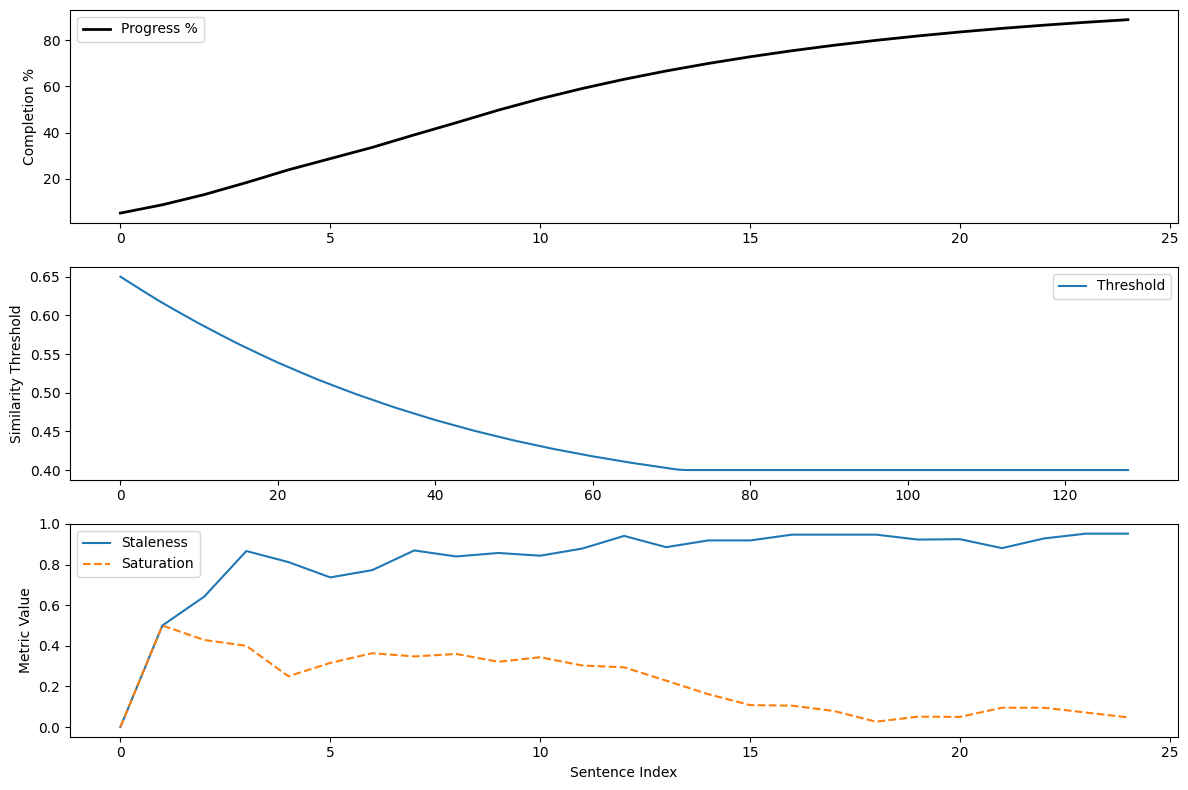


Final Groups:

Group 1:
  - A P J Abdul Kalam Departing speech
Friends, I am delighted to address you all, in the country and those living abroad, after
working with you and completing five beautiful and eventful years in Rashtrapati
Bhavan.
  - Dear Citizens, I conclude my address by sharing with you my mission in life which is to
bring connectivity between billion hearts and minds of the people of India in our
multicultural society and to embed the self confidence that "we can do it".

Group 2:
  - Today, it is indeed a thanks giving occasion.
  - With this spirit, I am extremely happy that we are
on the right path.
  - Finally let me thank each one of you for showering your love and affection on me
throughout the last five years by your cooperation and support.
  - May God bless you.

Group 3:
  - I would like to narrate, how I
enjoyed every minute of my tenure enriched by the wonderful association from each one
of you, hailing from different walks of life, be it politics, science 

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer, util
import spacy
import torch
import matplotlib.pyplot as plt
from typing import List

# Load sentence model and spacy model
nlp = spacy.load("en_core_web_sm")
sentModel = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
def compute_staleness(groups: List[List[int]], current_index: int, window: int) -> float:
    """Compute staleness with dynamic window size."""
    stale_count = 0
    for group in groups:
        last_active = max(group)
        if current_index - last_active > window:
            stale_count += 1
    return stale_count / len(groups) if groups else 0

def compute_saturation(groups: List[List[int]], current_index: int) -> float:
    """Measure how many groups are recently created."""
    if current_index < 10 or not groups:
        return 0.0
    lookback = min(20, current_index//2)  # Adaptive lookback window
    new_groups = sum(1 for group in groups if min(group) >= current_index - lookback)
    return min(1.0, new_groups / len(groups))

def estimate_speech_length(groups: List[List[int]], current_index: int) -> int:
    """Predict speech length with more conservative estimates."""
    if current_index < 15:
        return 50  # Very conservative initial estimate
    topic_rate = len(groups) / current_index
    estimated_length = int(3.8 / max(topic_rate, 0.01))  # Prevents division by zero
    return min(400, max(40, estimated_length))  # Tighter bounds

def calculate_progress(staleness: float, saturation: float, pos: int, est_length: int) -> float:
    """Combine metrics into unified progress percentage (0-100)."""
    # Sigmoid blending weights (more staleness weight later)
    staleness_weight = 0.3 + 0.5 * (pos/est_length) ** 2
    combined = (staleness_weight * staleness +
               (1-staleness_weight) * (1-saturation))

    # Constrain by linear position and smooth
    linear_progress = pos / est_length
    progress = 0.3 * linear_progress + 0.7 * combined
    return min(99, max(1, progress * 100))  # Always 1-99%

def linear_grouping_quantified(
    sentences: List[str],
    model,
    initial_threshold: float = 0.65,
    min_threshold: float = 0.4
):
    # Initialize data structures
    embeddings, groups, group_embeddings = [], [], []
    threshold_history, progress_history = [], []
    staleness_history, saturation_history = [], []

    # Adaptive parameters
    current_window = 5
    predicted_length = 50
    smoothed_progress = 0

    for i, sentence in enumerate(sentences):
        # Process current sentence
        new_embedding = model.encode(sentence, convert_to_tensor=True)
        embeddings.append(new_embedding)

        if i == 0:
            groups.append([0])
            group_embeddings.append(new_embedding)
            threshold_history.append(initial_threshold)
            continue

        # Adaptive threshold decay
        current_threshold = max(
            min_threshold,
            threshold_history[-1] * (1 - 0.01 * (1 - smoothed_progress/100))
        )

        # Grouping logic
        best_sim, best_group = -1, None
        for group_idx, group_embed in enumerate(group_embeddings):
            sim = util.pytorch_cos_sim(new_embedding, group_embed).item()
            if sim > best_sim:
                best_sim, best_group = sim, group_idx

        if best_sim >= current_threshold:
            groups[best_group].append(i)
            group_embeddings[best_group] = torch.mean(
                torch.stack([embeddings[idx] for idx in groups[best_group]]),
                dim=0
            )
        else:
            groups.append([i])
            group_embeddings.append(new_embedding)

        threshold_history.append(current_threshold)

        # Update every 5 sentences
        if i % 5 == 0:
            predicted_length = estimate_speech_length(groups, i)
            current_window = max(3, min(10, int(0.1 * predicted_length)))

            staleness = compute_staleness(groups, i, current_window)
            saturation = compute_saturation(groups, i)

            current_progress = calculate_progress(
                staleness=staleness,
                saturation=saturation,
                pos=i,
                est_length=predicted_length
            )
            smoothed_progress = 0.9 * smoothed_progress + 0.1 * current_progress

            staleness_history.append(staleness)
            saturation_history.append(saturation)
            progress_history.append(smoothed_progress)

            print(f"Pos {i:3d}: Progress={smoothed_progress:5.1f}% | "
                  f"Staleness={staleness:.2f} | "
                  f"Saturation={saturation:.2f} | "
                  f"EstLen={predicted_length}")

    # Enhanced visualization
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(progress_history, label='Progress %', color='black', linewidth=2)
    plt.ylabel("Completion %")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(threshold_history, label='Threshold')
    plt.ylabel("Similarity Threshold")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(staleness_history, label='Staleness')
    plt.plot(saturation_history, label='Saturation', linestyle='--')
    plt.xlabel("Sentence Index")
    plt.ylabel("Metric Value")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\nFinal Groups:")
    for idx, group in enumerate(groups):
        print(f"\nGroup {idx+1}:")
        for sent_idx in group:
            print(f"  - {sentences[sent_idx]}")

# Example usage
linear_grouping_quantified(result, sentModel)